# Accelerometer/Keyboard data report (Typing)

## Read CSV Files

In [3]:
import pandas as pd

accel_columns = ['Timestamp', 'X', 'Y', 'Z']
kb_columns = ['Timestamp', 'P']

dco_df = pd.read_csv('Data/DCO_accel_COM6_2MHz_2.csv', names=accel_columns);
dco = dco_df.as_matrix();

kb_df = pd.read_csv('Data/keyboard_COM12_4MHz_2.csv', names=kb_columns);
kb = kb_df.as_matrix();

# find difference in sizes
diff = abs(len(kb) - len(dco));

## Some data exploration

In [4]:
# Let's see what the drift looks like right now!
import numpy as np
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook();

# First few values are garbage
dco = dco[50:,:];
kb = kb[50:,:];

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

kb_fixed = kb;
dco_fixed = dco;

# Plot dco time vs keyboard time
kb_time = kb_fixed[:,0];
dco_time = dco_fixed[:,0];

max_samples = max(len(kb_time), len(dco_time));

# Compute elapsed times
kb_time = kb_time - kb_time[0];
dco_time = dco_time - dco_time[0];

kb_time = kb_time[::-1]

# Interpolate the data to calculate drift
ep = kb_time[-1];
ep2 = dco_time[-1];

furthest_time = max(ep, ep2);

x = np.linspace(0, ep, num=len(kb_time), endpoint=True)
x2 = np.linspace(0, ep2, num=len(dco_time), endpoint=True)

f = interp1d(kb_time, x);
f2 = interp1d(dco_time, x2)

xnew = np.linspace(0, furthest_time, num=max_samples, endpoint=True);

#drift = abs(f(xnew) - f2(xnew))

#plt.plot(drift, label="Drift")
#plt.legend(loc="upper left");
#plt.grid();
#plt.show();


### High pass filter

In [5]:
from scipy import signal
# Quick define a high pass filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

freq = 100 #Hz
cutoff = 30;

## Plot key presses vs accelerometer activity

C:\Users\Ala\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


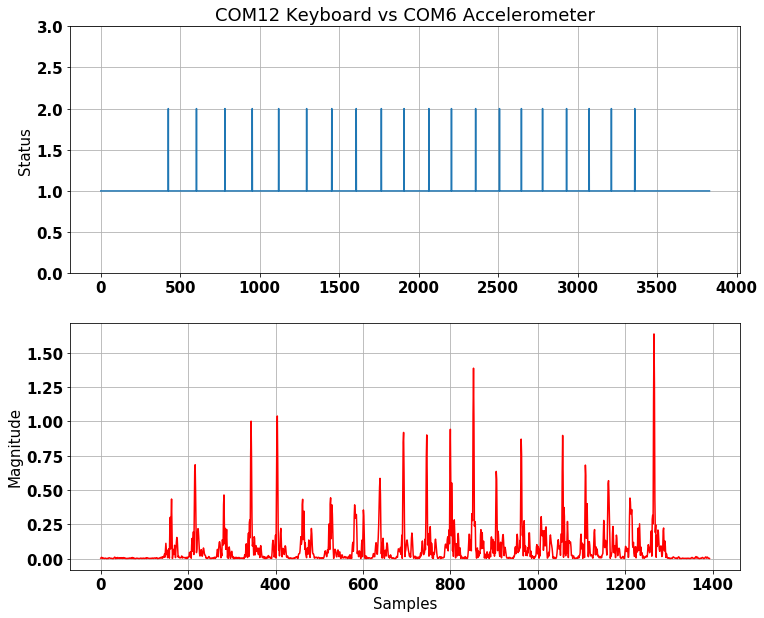

In [6]:
import numpy as np

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

# compute DCO magnitude
dco_mag = np.square(dco[:,1]) + np.square(dco[:,2]) + np.square(dco[:,3]);
dco_mag = np.sqrt(dco_mag);

filtered_dco = butter_highpass_filter(dco_mag, cutoff, freq);
filtered_dco = abs(filtered_dco)

# Keyboard press/not pressed values
pValues = kb[:,1];
kb_time_raw = kb[:,0];

# Plot both accelerometers
f, axes = plt.subplots(2);
        
ax1 = axes[0];
ax2 = axes[1];

ax1.plot(pValues);
ax1.grid();
ax1.set_ylim([0, 3]);
ax1.set_ylabel("Status")
#ax1.vlines([linepos], 0, 15, colors='k');
ax1.set_title('COM12 Keyboard vs COM6 Accelerometer');
time_shift = 80;
#filtered_dco -= filtered_dco.mean();
#filtered_dco /= filtered_dco.std();

filtered_dco = np.roll(filtered_dco,time_shift);
#dco_time = np.roll(dco_time, 20);

l = ax2.plot(filtered_dco, color='r');
ax2.set_ylabel("Magnitude")
ax2.set_xlabel("Samples")

#ax2.vlines([linepos], 0, 15, colors='k');
ax2.grid();

plt.show();


## Train Classifier for Handshake recognition and reconstruct events

In [7]:
# Perform some classification to find the area with the handshaking activity
# Once area has been located on both COM9 and COM6, it becomes possible to compute offset and skew
# This is just a demo, with a classifier constructed from the reference node (crystal) and
# applied to the synchronizing node (DCO). 

import AccelerometerFeatures as af
import EventAnalyzer as ea
from sklearn import svm
from sklearn.model_selection import cross_val_score


# Create feature extraction object
ae = af.AccelerometerFeatures();
    
# Time is in microseconds, should convert to milliseconds
window_size = 12;     # in millis, with 100Hz each window should have ~9-10 samples
window_overlap = 2;

# extract crystal accelerometer features
X, y, w = ae.extract_features_from_files("dco", window_size, window_overlap);

C = 1.0;  # SVM regularization parameter

# Fit SVC onto crystal data
svc = svm.SVC(kernel='poly', C=C);
svc.fit(X, y)

# To predict, use the following lines. (These are used in the next step anyway)
X2, y2, w2 = ae.extract_features(dco, window_size, window_overlap);
#X3, y3, w3 = ae.extract_features(crystal, window_size, window_overlap);

# Compute cross validation accuracy score
print(cross_val_score(svc, X2, y2, scoring='accuracy'))
print(cross_val_score(svc, X2, y2, scoring='average_precision'))
print(cross_val_score(svc, X2, y2, scoring='recall'))
#cross_val_score(svc, X3, y3, scoring='accuracy')

# Process to reconstruct the signal and detect the areas with 
# handshake activity in it.


# Instantiate event analyzer
analyzer = ea.EventAnalyzer();

# Plot both accelerometers events for display purposes
#f, (ax1,ax2) = plt.subplots(2);

#ax1 = axes[0];
#ax2 = axes[1];

#ax1.legend(handles=[e,ne], loc="upper left")
all_keyboard_events = analyzer.find_keyboard_events(kb, window_size, window_overlap, ax1);
#plt.ylim([0, 3]);
#plt.grid();

dco_events = analyzer.find_events(dco, window_size, window_overlap, svc, ax2);
#ax2.grid();
#ax2.legend(handles=[e,ne], loc="upper left")
#plt.show()

# Retrieve all events
all_dco_events = analyzer.find_events(dco, window_size, window_overlap, svc, None);

print(len(all_dco_events))
print(len(all_keyboard_events))

# remove last element 
#all_dco_events = all_dco_events[:-1];
all_keyboard_events = all_keyboard_events[:-1];

[ 0.85        0.92307692  0.94736842]
[ 0.97486555  0.99451595  1.        ]
[ 0.83333333  0.91304348  0.91304348]
19
20


## Compute X-Correlation between COM12 Keyboard and COM6 accelerometer

In [8]:
###### import scipy as sp
from scipy.signal import correlate
np.seterr(divide='ignore', invalid='ignore')

# Sampling rate
SRATE = 100;

# Compute cross correlation between every two events found
# NOTE: The number of events on node i and node j MUST be the same
#for i in range(0, len(all_keyboard_events)):   # Length of this should be = all_dco_events
#    kb_window = kb[all_keyboard_events[i][0]:all_keyboard_events[i][1],:];
#    dco_window = dco[all_dco_events[i][0]: all_dco_events[i][1],:];
kb_window = kb;
dco_window = dco;

# press/notpress values
pValues = kb_window[:,1];

# get magnitude of dco
dmag = np.square(dco_window[:,1]) + np.square(dco_window[:,2]) + np.square(dco_window[:,3]);
dmag = np.sqrt(dmag);

# delta time array to match xcorr
nsamples = len(dco_window);

# regularize datasets by subtracting mean and dividing by s.d.
pmag = pValues.astype(float);

pmag -= pmag.mean();
pmag /= pmag.std();

dmag -= dmag.mean();
dmag /= dmag.std();

# Find X-Correlation of the anharmonic signals
xcorr = correlate(pmag,dmag);

# delta time array to match xcorr
t = np.asarray(dco_time);
#dt = np.linspace(-t[-1], t[-1], 2*nsamples-1)
#recovered_sample_shift = dt[xcorr.argmax()]

dt = np.arange(1-nsamples, nsamples);
recovered_sample_shift = dt[xcorr.argmax()];
offset = abs(recovered_sample_shift * SRATE);

print ("Recovered offset: ", recovered_sample_shift, " samples, or " , offset, " microseconds for 100Hz sample rate");

# Now we train our LS estimator 
    

Recovered offset:  -1393  samples, or  139300  microseconds for 100Hz sample rate


## Compute event onsets 

The Least Squares Estimator (LSE) $\hat{\beta}$ is that value of $b$ that minimizes

\begin{equation*}
\sum^{n}_{i=1} (y_i - f_b(x_i))^2
\end{equation*}

We will now cycle through the events we have found in Section 1.6 and mark all the event onsets for the DCO (node $j$, to be synchronized) and the crystal (node $i$, reference node).

Variance score: 0.90 
 where 1.00 indicates perfect prediction
Offset detected:  139300  microseconds
Skew detected:  [ 3.03554684]


C:\Users\Ala\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


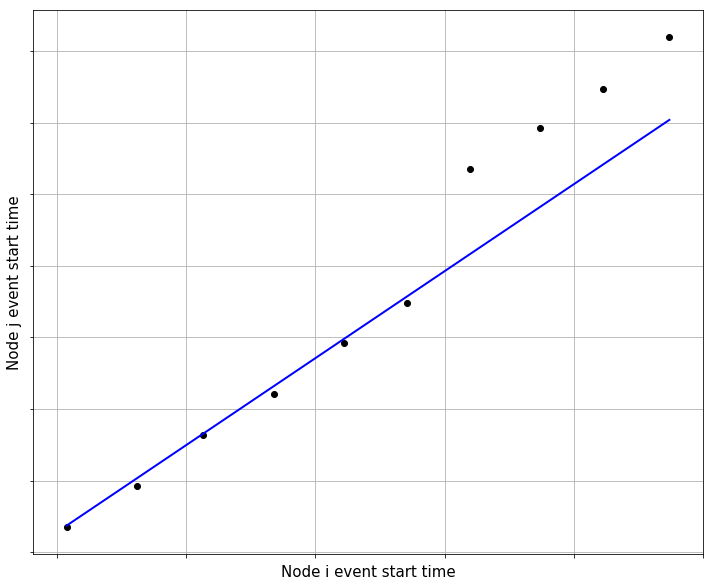

In [9]:
# Cycle through events found in Section 1.6 and find all event onsets for DCO and Crystal.
import scipy.optimize as optimization
from sklearn import linear_model

# Chose a model that will create bimodality.
def func(x, a, b):
    return a + b*b*x  # Term b*b will create bimodality.


keyboard_start_times = [];
kb_coeff = .337;
for c in all_keyboard_events:
    keyboard_start_times.append([kb[c[0]][0]*kb_coeff]);

dco_start_times = [];
for d in all_dco_events:
    dco_start_times.append(dco[d[0]][0] + offset)
    
# Split into training and test data
X = np.asarray(keyboard_start_times);
Y = np.asarray(dco_start_times);

# Need MORE test sets
length = 9;

x_train = X[:length];
x_test = X[length:];

y_train = Y[:length];
y_test = Y[length:];

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train);

skew = regr.coef_;

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test) , '\n where 1.00 indicates perfect prediction')

# Plot outputs
plt.plot(x_test, regr.predict(x_test), color='blue',
         linewidth=2)

plt.scatter(x_test, y_test,  color='black')

frame = plt.gca()

plt.grid(True);

frame.xaxis.set_major_formatter(plt.NullFormatter())
frame.yaxis.set_major_formatter(plt.NullFormatter())

plt.xlabel("Node i event start time")
plt.ylabel("Node j event start time")

print ("Offset detected: ", abs(offset), " microseconds")
print ("Skew detected: ", skew)

plt.show()

## Drift Improvement

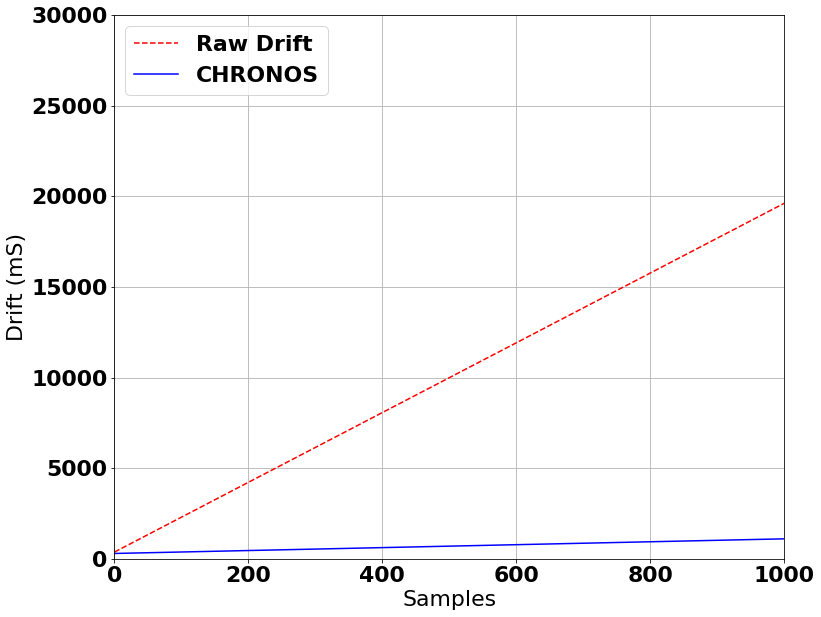

Total Drift:  192152.61007  ms
Average Drift:  13784.2618415  ms
Absolute Error:  1378.42618415
CRONOS Total Drift:  11947.2419134  ms
CRONOS Average Drift:  857.04748303  ms
CRONOS Absolute Error:  85.704748303
Drift reduced by 93.78%


In [10]:
from sklearn.metrics import mean_absolute_error

#sns.set(style="whitegrid")

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)
font = {'family' : 'DejaVu Sans',
        'weight' : 'black',
        'size'   : 22}

matplotlib.rc('font', **font)

kb_time = kb_time_raw;
ddtime = dco_time;

diff = abs(len(kb_time) - len(ddtime));

if(len(kb_time) > len(ddtime)):
    kb_time = kb_time_raw[:-diff];
else:
    ddtime = ddtime[:-diff];

samples = np.linspace(0, len(kb_time), num=len(kb_time))

# Compute elapsed times
kb_time = kb_time - kb_time[0];
ddtime = ddtime - ddtime[0];

# Plot drift 
drift = abs(kb_time - ddtime);
old_kb_time = kb_time;
# Apply the estimated skew and offset
kb_time = (kb_time * skew) + offset;

adjusted_drift = abs(kb_time - ddtime);

xp = np.linspace(0, len(adjusted_drift), 100);

deg = 1;
z1 = np.poly1d(np.polyfit(samples, drift/1000, deg))
z2 = np.poly1d(np.polyfit(samples, adjusted_drift/1000, deg));


plt.plot(xp, z1(xp), 'r--', label="Raw Drift");
plt.plot(xp, z2(xp), 'b-', label="CHRONOS");

#f, axes = plt.subplots(2);
#ax1.plot(xp, z1(xp), 'r-', label="Raw Drift");
#ax1.plot(xp, z2(xp), 'b-', label="Our Method");

#plt.plot(drift, 'r', label="Raw Drift");
#plt.plot(adjusted_drift, 'b', label="Our Method");



plt.legend(loc="upper left")
plt.xlim([0, 1000]);
plt.ylim([0, 30000]);
plt.xlabel("Samples")
plt.ylabel("Drift (ms)")
plt.tick_params
plt.grid()
plt.show()

# Plot average improvement over no-drift
avg_drift = sum(drift) / len(drift);
print("Total Drift: ", sum(drift)/100000, " ms");
print ("Average Drift: ", avg_drift/1000, " ms");
print ("Absolute Error: ", mean_absolute_error(old_kb_time, ddtime)/10000)
adjusted_drift_avg = sum(adjusted_drift) / len(adjusted_drift);
print("CRONOS Total Drift: ", sum(adjusted_drift)/100000, " ms");
print ("CRONOS Average Drift: ", adjusted_drift_avg/1000, " ms");
print ("CRONOS Absolute Error: ", mean_absolute_error(kb_time, ddtime)/10000)
decrease = avg_drift - adjusted_drift_avg;
print("Drift reduced by %.2f%%" % ((decrease / avg_drift) * 100))
